# Anees Chunara
# HW 2


# Question 1

In [2]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Load the data
df = pd.read_csv('clean_subway.csv', low_memory=False)

# Convert transit_timestamp to datetime
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

# Extract hour from the timestamp
df['hour'] = df['transit_timestamp'].dt.hour

# Group by station_complex_id and calculate the average ridership per hour
station_avg_ridership = df.groupby('station_complex_id').agg(
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first'),
    station_complex=('station_complex', 'first'),
    avg_ridership=('ridership', 'mean')
).reset_index()

# Create a map centered around New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Define a function to color stations based on average ridership
def get_color(avg_ridership):
    if avg_ridership < 50:
        return 'green'
    elif 50 <= avg_ridership < 200:
        return 'orange'
    else:
        return 'red'

# Add a marker cluster for better visualization
marker_cluster = MarkerCluster().add_to(nyc_map)

# Add markers to the map
for _, row in station_avg_ridership.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color=get_color(row['avg_ridership']),
        fill=True,
        fill_color=get_color(row['avg_ridership']),
        fill_opacity=0.7,
        popup=folium.Popup(f"Station: {row['station_complex']}<br>Avg Ridership: {row['avg_ridership']:.2f}", max_width=250)
    ).add_to(marker_cluster)

# Save the map to an HTML file
nyc_map.save('nyc_subway_map.html')

# If using Jupyter or an environment that supports it, display the map
nyc_map


# BONUS

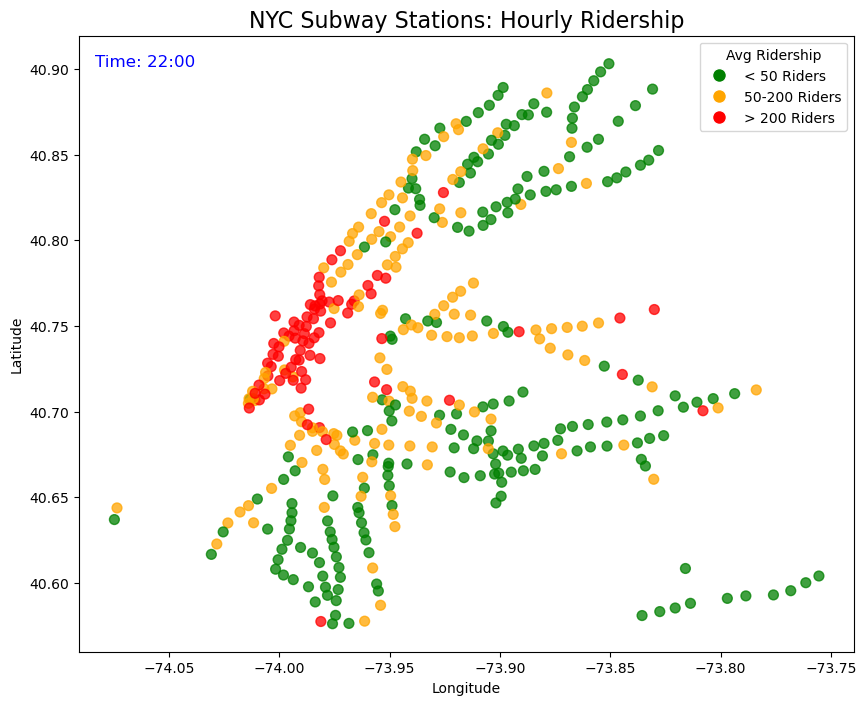

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.lines import Line2D

# Load the dataset
df = pd.read_csv('clean_subway.csv', low_memory=False)

# Convert transit_timestamp to datetime
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])

# Extract hour from the timestamp
df['hour'] = df['transit_timestamp'].dt.hour

# Group by station_complex_id and hour to calculate the average ridership
hourly_ridership = df.groupby(['station_complex_id', 'hour']).agg(
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first'),
    station_complex=('station_complex', 'first'),
    avg_ridership=('ridership', 'mean')
).reset_index()

# Define the time range (e.g., 6 AM to 10 PM)
start_hour = 6
end_hour = 22

# Set up the figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 8))
plt.title("NYC Subway Stations: Hourly Ridership", fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create a GeoDataFrame for mapping
gdf = gpd.GeoDataFrame(hourly_ridership, geometry=gpd.points_from_xy(hourly_ridership.longitude, hourly_ridership.latitude))

# Function to get color based on ridership
def get_color(avg_ridership):
    if avg_ridership < 50:
        return 'green'
    elif 50 <= avg_ridership < 200:
        return 'orange'
    else:
        return 'red'

# Plot base points for the first frame
scat = ax.scatter(gdf['longitude'], gdf['latitude'], s=50, edgecolor='k', alpha=0.75)

# Text annotation for time of day
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, color='blue')

# Update function for each frame
def update(hour):
    current_data = hourly_ridership[hourly_ridership['hour'] == hour]
    
    colors = [get_color(r) for r in current_data['avg_ridership']]
    
    scat.set_offsets(np.c_[current_data['longitude'], current_data['latitude']])
    scat.set_color(colors)
    
    # Update the time annotation
    time_text.set_text(f"Time: {hour}:00")
    
    return scat, time_text

# Custom legend for the color categories
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='< 50 Riders', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='50-200 Riders', markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='> 200 Riders', markerfacecolor='red', markersize=10)
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='upper right', title="Avg Ridership")

# Create the animation
ani = FuncAnimation(fig, update, frames=range(start_hour, end_hour + 1), interval=500, blit=True)

# Save the animation as a video file
ani.save('nyc_subway_ridership_animation.mp4', writer='ffmpeg', fps=2)

# Display the animation (if you're using Jupyter)
plt.show()


# Video Link: https://youtu.be/mlFT4aIkhXs

# Question 2

In [5]:
import pandas as pd
from scipy.spatial import KDTree

# Load the datasets
arrests_df = pd.read_csv('NYPD_Arrests_Data__Historic__20240916.csv', low_memory=False)
subway_df = pd.read_csv('clean_subway.csv', low_memory=False)

# Step 1: Filter the arrest data for "THEFT OF SERVICES" offenses (turnstile jumping)
filtered_arrests_df = arrests_df[arrests_df['OFNS_DESC'].str.contains('THEFT OF SERVICES', case=False, na=False)].copy()

# Step 2: Prepare KDTree for the subway station coordinates
# Create a list of (latitude, longitude) tuples for the subway stations
subway_coords = subway_df[['latitude', 'longitude']].values
# Create the KDTree from subway coordinates
subway_tree = KDTree(subway_coords)

# Step 3: Function to find the closest subway station using KDTree
def find_closest_station_kdtree(lat, lon, subway_tree, subway_df):
    distance, index = subway_tree.query([lat, lon])  # Find closest point in KDTree
    closest_station = subway_df.iloc[index]['station_complex']  # Get station name by index
    return closest_station

# Apply the function to find the closest station for each filtered arrest
filtered_arrests_df.loc[:, 'closest_subway_station'] = filtered_arrests_df.apply(
    lambda row: find_closest_station_kdtree(row['Latitude'], row['Longitude'], subway_tree, subway_df), axis=1)

# Step 4: Export the resulting dataframe to CSV
filtered_arrests_df.to_csv('enriched_arrests_with_subway_kdtree.csv', index=False)

# Output result for validation
print(filtered_arrests_df.head())


      ARREST_KEY ARREST_DATE  PD_CD                         PD_DESC  KY_CD  \
2080   221814178  12/14/2020  475.0  UNAUTH. SALE OF TRANS. SERVICE  343.0   
2422   221248523  12/02/2020  475.0  UNAUTH. SALE OF TRANS. SERVICE  343.0   
3762   222178977  12/23/2020  475.0  UNAUTH. SALE OF TRANS. SERVICE  343.0   
5389   221252314  12/02/2020  475.0  UNAUTH. SALE OF TRANS. SERVICE  343.0   
5496   221507466  12/08/2020  475.0  UNAUTH. SALE OF TRANS. SERVICE  343.0   

              OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  ARREST_PRECINCT  \
2080  THEFT OF SERVICES  PL 1651601          M           M                7   
2422  THEFT OF SERVICES  PL 1651601          M           M               17   
3762  THEFT OF SERVICES  PL 1651601          M           M               25   
5389  THEFT OF SERVICES  PL 1651601          M           M               19   
5496  THEFT OF SERVICES  PL 1651601          M           B               44   

      JURISDICTION_CODE AGE_GROUP PERP_SEX       PERP_RA

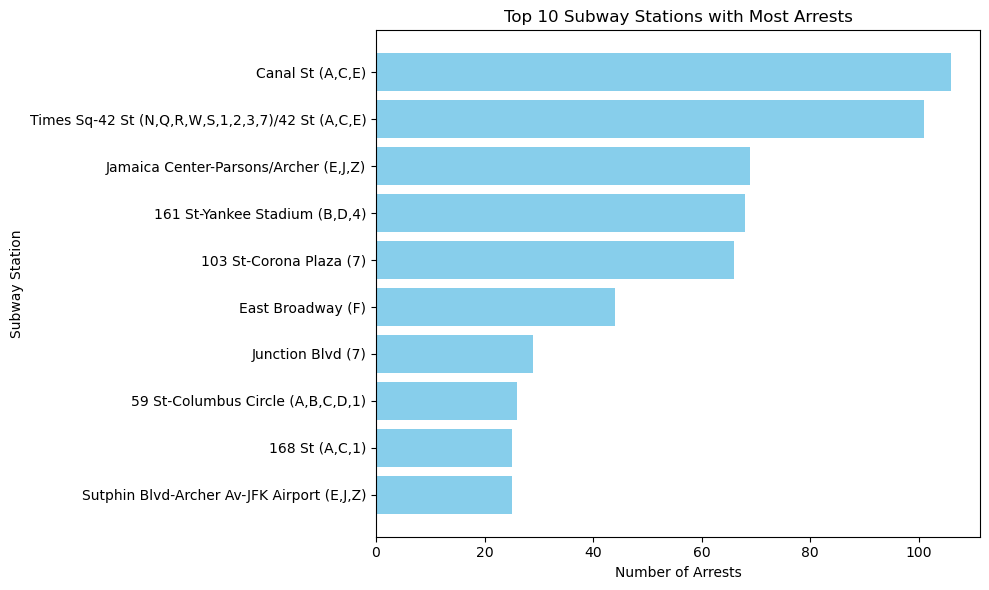

In [6]:
import matplotlib.pyplot as plt

# Step 1: Aggregate the arrests by the closest subway station
station_arrest_counts = filtered_arrests_df.groupby('closest_subway_station').size().reset_index(name='arrest_count')

# Step 2: Get the top 10 subway stations with the highest number of arrests
top_10_stations = station_arrest_counts.nlargest(10, 'arrest_count')

# Step 3: Plot a bar chart of the top 10 stations with most arrests
plt.figure(figsize=(10, 6))
plt.barh(top_10_stations['closest_subway_station'], top_10_stations['arrest_count'], color='skyblue')

# Step 4: Customize the plot
plt.xlabel('Number of Arrests')
plt.ylabel('Subway Station')
plt.title('Top 10 Subway Stations with Most Arrests')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest values on top
plt.tight_layout()

# Show the plot
plt.show()


# Interactive map

In [8]:
import folium
from folium.plugins import MarkerCluster

# Step 1: Create a base map centered around the mean of the arrests' latitudes and longitudes
mean_lat = filtered_arrests_df['Latitude'].mean()
mean_lon = filtered_arrests_df['Longitude'].mean()
mymap = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

# Step 2: Group arrests by latitude and longitude to count the number of arrests per location
arrest_counts = filtered_arrests_df.groupby(['Latitude', 'Longitude', 'closest_subway_station']).size().reset_index(name='arrest_count')

# Step 3: Add a marker cluster for the arrests, including the number of arrests and closest station in the popup
arrest_cluster = MarkerCluster(name='Turnstile Jumping Arrests').add_to(mymap)

for _, row in arrest_counts.iterrows():
    popup_text = f"Number of arrests: {row['arrest_count']}<br>Closest Subway Station: {row['closest_subway_station']}"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(arrest_cluster)

# Step 4: Optionally draw lines between each arrest and its nearest subway station
for _, row in filtered_arrests_df.iterrows():
    closest_station = subway_df[subway_df['station_complex'] == row['closest_subway_station']].iloc[0]
    folium.PolyLine(
        locations=[(row['Latitude'], row['Longitude']), 
                   (closest_station['latitude'], closest_station['longitude'])],
        color='gray',
        weight=2,
        opacity=0.5
    ).add_to(mymap)

# Step 5: Add layer control and display the map
folium.LayerControl().add_to(mymap)

# Save the map to an HTML file
mymap.save("turnstile_jumping_map_with_arrests_and_stations.html")

# Display the map
mymap
